# TP3: Problemas NP-Completos

In [1]:
import time
import random
# pip install matplotlib
from matplotlib import pyplot as plt
# pip install tabulate
from tabulate import tabulate
# pip install pulp
import pulp


### ¿Hitting-Set Problem está en NP?

In [2]:
#Verificamos la solucion polinomialmente
def verificar_solucion(B, C, k):
    if len(C) > k:
        return False
    satisface_Bi = [False] * len(B)

    for c in C:                      # O(#C) 
        for i in range(len(B)):
            if c in B[i]:            # O(#B[i])
                satisface_Bi[i] = True

    return all(satisface_Bi)      # O(#B)         

### Funciones auxiliares


In [2]:
# Recibe el path con el archivo a leer.
# Leemos y devolvemos un array de listas, donde cada lista posee los jugadores que piden los diferentes medios y periodistas.
def obtener_pedidos_de_la_prensa(path):
    with open(path, 'r') as archivo:
        lineas = archivo.readlines()

    pedidos_de_la_prensa = []

    for linea in lineas:
        preseleccion_linea = linea.strip().split(',')
        pedidos_de_la_prensa.append(preseleccion_linea)

    return pedidos_de_la_prensa

# Recibe una lista de listas, donde cada lista posee los jugadores que piden los diferentes medios y periodistas.
# Devuelve un set con todos los jugadores que son solicitados por la prensa.
def obtener_todos_jugadores(pedidos_de_la_prensa):
    jugadores = set()
    for pedido in pedidos_de_la_prensa:
        for jugador in pedido:
            jugadores.add(jugador)
    return jugadores

In [4]:
# Clase que representa el resultado.
# Recibe el nombre del archivo, la cantidad minima de jugadores que resuelve y los jugadores que se seleccionaron como solucion.
class Resultado:
    def __init__(self, nombre_archivo, cantidad_minima, jugadores):
        self.nombre_archivo = nombre_archivo
        self.cantidad_minima = cantidad_minima
        self.jugadores = jugadores
        

def obtener_resultados_esperados(nombre_archivo):
    with open(nombre_archivo, 'r') as archivo:
        contenido = archivo.read() 
    resultados = []

    # Separa el contenido en bloques
    bloques = contenido.split('\n\n')
    
    # Itera a través de cada bloque y busca ".txt" (para obtener el nombre del archivo) y 
    # "Cantidad" (para obtener la cantidad minima de jugadores que resuelve y los jugadores que se seleccionaron como solucion)
    for bloque in bloques:
        nombre_archivo = ''
        cantidad_minima = 0
        jugadores = []

        lineas = bloque.split('\n')
        for linea in lineas:
            if ".txt" in linea:
                nombre_archivo = linea
            if 'Cantidad' in linea:
                cantidad_minima = int(linea.split(":")[1].split("(")[0].strip())
                jugadores_linea = linea.split("(")[1].split(")")[0]
                jugadores = [jugador.strip() for jugador in jugadores_linea.split(",")]
                resultados.append(Resultado(nombre_archivo, cantidad_minima, jugadores))

    return resultados


### Sets de datos

In [5]:
#Paths de los archivos de la catedra
path_5 = 'sets/sets de la catedra/5.txt'
path_7 = 'sets/sets de la catedra/7.txt'
path_10_pocos = 'sets/sets de la catedra/10_pocos.txt'
path_10_todos = 'sets/sets de la catedra/10_todos.txt'
path_10_varios = 'sets/sets de la catedra/10_varios.txt'
path_15 = 'sets/sets de la catedra/15.txt'
path_20 = 'sets/sets de la catedra/20.txt'
path_50 = 'sets/sets de la catedra/50.txt'
path_75 = 'sets/sets de la catedra/75.txt'
path_100 = 'sets/sets de la catedra/100.txt'
path_200 = 'sets/sets de la catedra/200.txt'
resultados_sets_catedra = 'sets/sets de la catedra/Resultados Esperados.txt'

#### Creación sets de datos propios

In [3]:
random.seed(0)

pedidos_de_prensa_max = obtener_pedidos_de_la_prensa(path_200)
universe = list(set([pedido for pedidos in pedidos_de_prensa_max for pedido in pedidos]))

def generar_instancia(universe_size, num_sets, max_set_size, min_set_size = 1):
    sets = [{universe[random.randint(0, universe_size)] for _ in range(random.randint(min_set_size, max_set_size))} for _ in range(num_sets)]
    return sets

def generar_instancia_cant_por_jugador_fija(universe_size, num_sets, cant_jugadores):
    i = 0
    sets = []
    for _ in range(num_sets):
        current_set = set()
        while i < cant_jugadores:
            nuevo_jugador = universe[random.randint(0, universe_size)]
            while nuevo_jugador in current_set:
                nuevo_jugador = universe[random.randint(1, universe_size)]
            current_set.add(nuevo_jugador)
            i += 1
        i = 0
        sets.append(current_set)
    return sets

def crear_archivos(sets, nombre_archivo):
    with open(nombre_archivo, 'w') as archivo:
        for set in sets:
            archivo.write(','.join(set) + '\n')

sets_5 = generar_instancia(30, 5, 6)
sets_15 = generar_instancia(30, 15, 15)
sets_20 = generar_instancia(30, 20, 6)
sets_50 = generar_instancia(30, 50, 2)

# Testear como aumenta el tiempo de ejecucion a medida que aumenta la cantidad periodista
def crear_archivos_periodistas():
    for i in range(0, 30001, 150):
        sets = generar_instancia(30, i, 7)
        crear_archivos(sets, 'sets/nuestros/performance_hasta_7_jugadores/' + str(i) + '_periodistas.txt')

# Testear con gran variacion de jugadores por periodista
def crear_archivos_periodistas_variacion_jugadores():
    for i in range(0, 30001, 150):
        sets = generar_instancia(30, i, 30)
        crear_archivos(sets, 'sets/nuestros/performance_hasta_31_jugadores/' + str(i) + '_periodistas.txt')

# Testear con gran variacion de jugadores por periodista
def crear_archivos_periodistas_min_jugadores():
    for i in range(0, 601, 150):
        sets = generar_instancia(30, i, 30, 3)
        crear_archivos(sets, 'sets/nuestros/performance_min_3_jugadores/' + str(i) + '_periodistas.txt')
       
# Ya que tarda mucho en ejecutar, lo dejamos comentado (se puede descomentar para ejecutarlo, pero los archivos ya se generaron)
# crear_archivos(sets_5, 'sets/nuestros/5.txt')
# crear_archivos(sets_15, 'sets/nuestros/15.txt')
# crear_archivos(sets_20, 'sets/nuestros/20.txt')
# crear_archivos(sets_50, 'sets/nuestros/50.txt')
# crear_archivos_periodistas()
# crear_archivos(generar_instancia(30,30000,7) , 'sets/nuestros/30k.txt')
# crear_archivos(generar_instancia(30,300000,7) , 'sets/nuestros/300k.txt')
# crear_archivos_periodistas_variacion_jugadores()
crear_archivos_periodistas_min_jugadores()

NameError: name 'random' is not defined

In [7]:
#Paths de los archivos nuestros
path_5_nuestro = 'sets/nuestros/5.txt'
path_15_nuestro = 'sets/nuestros/15.txt'
path_15_un_jugador_nuestro = 'sets/nuestros/15_un_jugador.txt'
path_20_nuestro = 'sets/nuestros/20.txt'
path_50_nuestro = 'sets/nuestros/50.txt'
path_30k_nuestro = 'sets/nuestros/30k.txt'
path_300k_nuestro = 'sets/nuestros/300k.txt'

### Obtención pedidos de la prensa

In [8]:
# Sets de la catedra
pedidos_prensa_catedra = {
    '5': obtener_pedidos_de_la_prensa(path_5),
    '7': obtener_pedidos_de_la_prensa(path_7),
    '10_pocos': obtener_pedidos_de_la_prensa(path_10_pocos),
    '10_varios': obtener_pedidos_de_la_prensa(path_10_varios),
    '10_todos': obtener_pedidos_de_la_prensa(path_10_todos),
    '15': obtener_pedidos_de_la_prensa(path_15),
    '20': obtener_pedidos_de_la_prensa(path_20),
    '50': obtener_pedidos_de_la_prensa(path_50),
    '75': obtener_pedidos_de_la_prensa(path_75),
    '100': obtener_pedidos_de_la_prensa(path_100),
    '200': obtener_pedidos_de_la_prensa(path_200)
}

# Resultados esperados
resultados_esperados = obtener_resultados_esperados(resultados_sets_catedra)

# Sets nuestros
pedidos_prensa_nuestro = {
    '5': obtener_pedidos_de_la_prensa(path_5_nuestro),
    '15': obtener_pedidos_de_la_prensa(path_15_nuestro),
    '15_un_jugador': obtener_pedidos_de_la_prensa(path_15_un_jugador_nuestro),
    '20': obtener_pedidos_de_la_prensa(path_20_nuestro),
    '50': obtener_pedidos_de_la_prensa(path_50_nuestro),
    '30k': obtener_pedidos_de_la_prensa(path_30k_nuestro),
    '300k': obtener_pedidos_de_la_prensa(path_300k_nuestro)
}


### Función verificadora

In [9]:
# Recibe una lista de listas (cada lista posee los jugadores que piden los diferentes medios y periodistas) y un 
# conjunto de jugadores que se seleccionaron como solucion.
# Verifica si el conjunto C cubre a todos los B_i
# Tomamos como base la verificación del Hitting-Set Problem y lo ajustamos para nuestro problema.
def verificar_solucion_para_Scaloni(B, C):
    for subconjunto in B:
        if not any(elemento in C for elemento in subconjunto):
            return False
    return True 

### Solución por Backtracking

In [10]:
# Recibe un pedido de la prensa (B_i) y una posible solucion (C)
# Verifica si el pedido del periodista esta satisfecho por la solucion.
# Devuelve True si el pedido esta satisfecho, False en caso contrario.
def satisfecho(pedido, solucion):
    return any(jugador in pedido for jugador in solucion)

# Obtiene el conjunto minimo de jugador que satisface a todos los periodistas.
# Recibe:
# - pedidos_de_prensa: una lista de listas (cada lista posee los jugadores que piden los diferentes medios y periodistas).
# - solucion_actual: una lista con los jugadores que se seleccionaron como solucion parcial.
# - i: indice que indica el pedido de prensa que se esta analizando.
# - solucion: una lista con los jugadores que se seleccionaron como mejor solucion.
def conjunto_minimo_para_Scaloni(pedidos_de_prensa, solucion_actual, i, solucion):
    cantidad_de_jugadores = len(solucion_actual)
    largo_solucion = len(solucion)

    if(largo_solucion > 0 and cantidad_de_jugadores == largo_solucion):
        return False

    pedido_actual = pedidos_de_prensa[i]

    if satisfecho(pedido_actual, solucion_actual):
        return conjunto_minimo_para_Scaloni(pedidos_de_prensa, solucion_actual, i + 1, solucion)


    for jugador in pedido_actual:
        if largo_solucion > 0 and cantidad_de_jugadores + 1 >= largo_solucion: 
            return True

        solucion_actual.append(jugador)
        cantidad_de_jugadores += 1

        if verificar_solucion_para_Scaloni(pedidos_de_prensa[i:], solucion_actual):
            solucion[:] = solucion_actual
            largo_solucion = cantidad_de_jugadores
        else:
            valido = conjunto_minimo_para_Scaloni(pedidos_de_prensa, solucion_actual, i + 1, solucion)

            if not valido:
                solucion_actual.pop()
                break 
        solucion_actual.pop()
        cantidad_de_jugadores -= 1

    return True

In [11]:
# Obtiene el conjunto minimo de jugador que satisface a todos los pedidios_de_prensa.
# Recibe:
# - pedidos_de_prensa: una lista de listas (cada lista posee los jugadores que piden los diferentes medios y periodistas).
# Devuele:
# - solucion: una lista con los jugadores que se seleccionaron como mejor solucion.
# - tiempo_ejecucion: tiempo de ejecucion en segundos que tardo en encontrar la solucion.
def solucion_para_Scaloni_BT(pedidos_de_prensa):
    solucion = []
    pedidos_ordenados = sorted(pedidos_de_prensa, key= len)
    tiempo_inicial = time.time()
    conjunto_minimo_para_Scaloni(pedidos_ordenados, [], 0, solucion)
    tiempo_final = time.time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial
    return solucion, tiempo_ejecucion

#### Chequeo solución 

##### 1 - Usando sets de la cátedra

In [12]:
# Lista de resultados y tiempos
resultados_obtenidos = []

# Iterar sobre los pedidos de prensa de la catedra
for key, value in pedidos_prensa_catedra.items():
  solucion, tiempo_ejecucion = solucion_para_Scaloni_BT(value)
  resultados_obtenidos.append((key, solucion, tiempo_ejecucion))


In [13]:
# Imprime los resultados obtenidos y los esperados en una tabla
resultados = []
i = 0
for resultado_esperado in resultados_esperados:
  key, solucion, tiempo_ejecucion = resultados_obtenidos[i]
  es_correcto = "Sí" if resultado_esperado.cantidad_minima == len(solucion) and \
    verificar_solucion_para_Scaloni(pedidos_prensa_catedra[key], solucion) else "No"
  resultados.append([resultado_esperado.nombre_archivo, resultado_esperado.cantidad_minima, len(solucion), es_correcto, tiempo_ejecucion]) 
  i += 1
print(tabulate(resultados, headers=['Archivo', 'Cantidad mínima esperada', 'Cantidad mínima obtenida', 'Se obtuvo el resultado esperado?', 'Tiempo de ejecución (s)']))

Archivo          Cantidad mínima esperada    Cantidad mínima obtenida  Se obtuvo el resultado esperado?      Tiempo de ejecución (s)
-------------  --------------------------  --------------------------  ----------------------------------  -------------------------
5.txt                                   2                           2  Sí                                                0.000130415
7.txt                                   2                           2  Sí                                                0.000129938
10_pocos.txt                            3                           3  Sí                                                0.00025177
10_varios.txt                           6                           6  Sí                                                0.00486016
10_todos.txt                           10                          10  Sí                                                0.211645
15.txt                                  4                           4  Sí 

##### 2 - Usando sets propios

In [14]:
# Lista de resultados y tiempos
resultados_obtenidos_nuestros = []
# Iterar sobre los pedidos de prensa de la catedra
for key, value in pedidos_prensa_nuestro.items():
  solucion, tiempo_ejecucion = solucion_para_Scaloni_BT(value)
  resultados_obtenidos_nuestros.append((key, solucion, tiempo_ejecucion))

In [15]:
# Imprime los resultados obtenidos y los esperados en una tabla
resultados_nuestros = []
i = 0
for resultado_obtenido in resultados_obtenidos_nuestros:
  archivo, solucion, tiempo_ejecucion = resultado_obtenido
  es_correcto = "Sí" if verificar_solucion_para_Scaloni(pedidos_prensa_nuestro[archivo], solucion) else "No"
  resultados_nuestros.append([archivo + '.txt', len(solucion), es_correcto , tiempo_ejecucion]) 
  i += 1
print(tabulate(resultados_nuestros, headers=['Archivo', 'Cantidad minima obtenida', 'Es válida la solución?', 'Tiempo de ejecución (s)']))

Archivo              Cantidad minima obtenida  Es válida la solución?      Tiempo de ejecución (s)
-----------------  --------------------------  ------------------------  -------------------------
5.txt                                       3  Sí                                      0.000181675
15.txt                                      4  Sí                                      0.000105858
15_un_jugador.txt                          14  Sí                                      9.44138e-05
20.txt                                      8  Sí                                      0.00143743
50.txt                                     20  Sí                                      0.00283408
30k.txt                                    31  Sí                                      0.101664
300k.txt                                   31  Sí                                      1.02698


### Solución por Programación Lineal

In [16]:
# Obtiene el conjunto minimo de jugador que satisface a todos los periodistas utilizando programacion lineal entera.
# Recibe:
# - pedidos_de_prensa: una lista de listas (cada lista posee los jugadores que piden los diferentes medios y periodistas).
# Devuele:
# - solucion: una lista con los jugadores que se seleccionaron como mejor solucion.
# - tiempo_ejecucion: tiempo de ejecucion en segundos que tardo en encontrar la solucion.
def solucion_para_Scaloni_LP(pedidos_de_prensa):
    tiempo_inicial = time.time()
    prob = pulp.LpProblem("Scaloni", pulp.LpMinimize)
    jugadores = obtener_todos_jugadores(pedidos_de_prensa)
    x = pulp.LpVariable.dicts("x", jugadores, lowBound=0, upBound=1, cat="Integer")
    prob += pulp.lpSum([x[i] for i in jugadores])
    for pedido in pedidos_de_prensa:
        prob += pulp.lpSum([x[jugador] for jugador in pedido]) >= 1
    prob.solve()
    solucion = [x[i] for i in jugadores if x[i].value() == 1]
    tiempo_final = time.time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial
    return solucion, tiempo_ejecucion

In [17]:
# Elimina el valor x_ de los nombres de los jugadores y reemplaza los _ por espacios. Devuelve el resultado modificado.
# Recibe:
# - resultado: solución obtenida por el metodo de programacion lineal entera, donde cada jugador es un objeto de la clase LpVariable.
def arreglar_resultado(resultado):
  if isinstance(resultado[0], str):
    return resultado
  return [jugador.name.replace('x_', '').replace('_', ' ') for jugador in resultado]

##### 1 - Sets de la cátedra

In [18]:
# Lista de resultados y tiempos
resultados_obtenidos_lp = []
# Iterar sobre los pedidos de prensa de la catedra
for archivo, value in pedidos_prensa_catedra.items():
  solucion, tiempo_ejecucion = solucion_para_Scaloni_LP(value)
  solucion = arreglar_resultado(solucion)
  resultados_obtenidos_lp.append((archivo, solucion, tiempo_ejecucion))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/carolina/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/091201ec94094157a25dd3d1c89361df-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/091201ec94094157a25dd3d1c89361df-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 62 RHS
At line 68 BOUNDS
At line 79 ENDATA
Problem MODEL has 5 rows, 10 columns and 21 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2 - 0.00 seconds
Cgl0004I processed model has 5 rows, 8 columns (8 integer (6 of which binary)) and 18 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 2
Cbc0038I Cleaned solution of 2
Cbc0038I Before mini branch and bound, 8 integers at bound fixed and 0 continuous of which 1 were inte

In [19]:
resultados_lp = []
i = 0
for resultado_esperado in resultados_esperados:
  archivo, solucion, tiempo_ejecucion = resultados_obtenidos_lp[i]
  es_correcto = "Sí" if resultado_esperado.cantidad_minima == len(solucion) and \
    verificar_solucion_para_Scaloni(pedidos_prensa_catedra[archivo],solucion) else "No"
  resultados_lp.append([resultado_esperado.nombre_archivo, resultado_esperado.cantidad_minima, len(solucion), es_correcto, tiempo_ejecucion]) 
  i += 1

print(tabulate(resultados_lp, headers=['Archivo', 'Cantidad mínima esperada', 'Cantidad mínima obtenida', 'Se obtuvo el resultado esperado?', 'Tiempo de ejecución (s)']))


Archivo          Cantidad mínima esperada    Cantidad mínima obtenida  Se obtuvo el resultado esperado?      Tiempo de ejecución (s)
-------------  --------------------------  --------------------------  ----------------------------------  -------------------------
5.txt                                   2                           2  Sí                                                  0.0217137
7.txt                                   2                           2  Sí                                                  0.0207009
10_pocos.txt                            3                           3  Sí                                                  0.0269222
10_varios.txt                           6                           6  Sí                                                  0.0313582
10_todos.txt                           10                          10  Sí                                                  0.0230372
15.txt                                  4                           4

##### 2 - Sets propios

In [20]:
# Lista de resultados y tiempos
resultados_obtenidos_lp_nuestros = []
# Iterar sobre los pedidos de prensa de la catedra
for archivo, value in pedidos_prensa_nuestro.items():
  solucion, tiempo_ejecucion = solucion_para_Scaloni_LP(value)
  solucion = arreglar_resultado(solucion)
  resultados_obtenidos_lp_nuestros.append((archivo, solucion, tiempo_ejecucion))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/carolina/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/07b0e89c370742338f5c99b0d30598c2-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/07b0e89c370742338f5c99b0d30598c2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 70 RHS
At line 76 BOUNDS
At line 91 ENDATA
Problem MODEL has 5 rows, 14 columns and 17 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3 - 0.00 seconds
Cgl0004I processed model has 5 rows, 8 columns (8 integer (4 of which binary)) and 11 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 3
Cbc0038I Cleaned solution of 3
Cbc0038I Before mini branch and bound, 8 integers at bound fixed and 0 continuous of which 1 were inte

In [21]:
# Imprime los resultados obtenidos y los esperados en una tabla
resultados_lp_nuestros = []
i = 0
for resultado_obtenido in resultados_obtenidos_lp_nuestros:
  archivo, solucion, tiempo_ejecucion = resultado_obtenido
  es_correcto = "Sí" if verificar_solucion_para_Scaloni(pedidos_prensa_nuestro[archivo],solucion) else "No"
  resultados_lp_nuestros.append([archivo + '.txt', len(solucion), es_correcto, tiempo_ejecucion]) 
  i += 1

print(tabulate(resultados_lp_nuestros, headers=['Archivo', 'Cantidad mínima obtenida', 'Es válida?', 'Tiempo de ejecución (s)']))

Archivo              Cantidad mínima obtenida  Es válida?      Tiempo de ejecución (s)
-----------------  --------------------------  ------------  -------------------------
5.txt                                       3  Sí                            0.0221534
15.txt                                      4  Sí                            0.0196552
15_un_jugador.txt                          14  Sí                            0.0159211
20.txt                                      8  Sí                            0.0205452
50.txt                                     20  Sí                            0.0194161
30k.txt                                    31  Sí                            2.95871
300k.txt                                   31  Sí                           40.5467


### Comparación de tiempos de ejecución según cantidad de jugadores

In [50]:
def pedidos_de_la_prensa_performance(path, max = 30001):
    pedidos_prensa_periodistas = []
    for i in range(150, max,150):
        pedidos_prensa_periodistas.append(obtener_pedidos_de_la_prensa(path + str(i) + '_periodistas.txt'))
    return pedidos_prensa_periodistas

# pedidos_prensa_perfo_7 = pedidos_de_la_prensa_performance('sets/nuestros/performance_hasta_7_jugadores/')
# pedidos_prensa_perfo_31 = pedidos_de_la_prensa_performance('sets/nuestros/performance_hasta_31_jugadores/')
pedidos_prensa_perfo_min_3 = pedidos_de_la_prensa_performance('sets/nuestros/performance_min_3_jugadores/', 601)
cantidad_periodistas = [i for i in range(150, 30000,150)]

: 

##### Algoritmo de Backtracking

In [23]:
def obtener_tiempos_ejecucion(pedidos_prensa):
    tiempos_ejecucion = []
    i = 0
    for pedidos in pedidos_prensa:
        _, tiempo_ejecucion = solucion_para_Scaloni_BT(pedidos)
        tiempos_ejecucion.append(tiempo_ejecucion)
        i += 1
    return tiempos_ejecucion

tiempos_ejecucion_perfo_7 = obtener_tiempos_ejecucion(pedidos_prensa_perfo_7)
tiempos_ejecucion_perfo_31 = obtener_tiempos_ejecucion(pedidos_prensa_perfo_31)

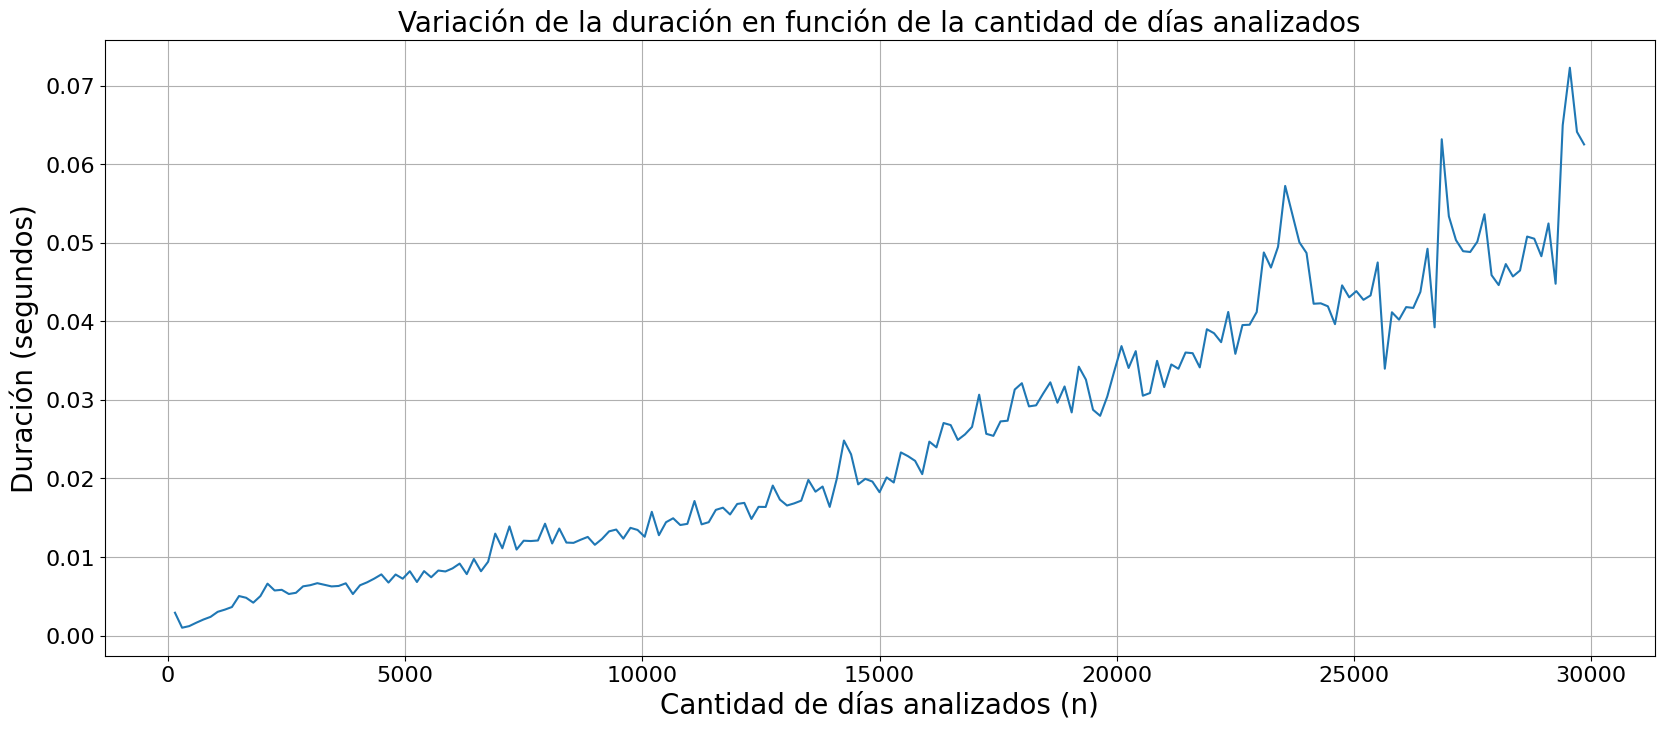

In [24]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_7)
plt.xlabel('Cantidad de días analizados (n)', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de días analizados', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

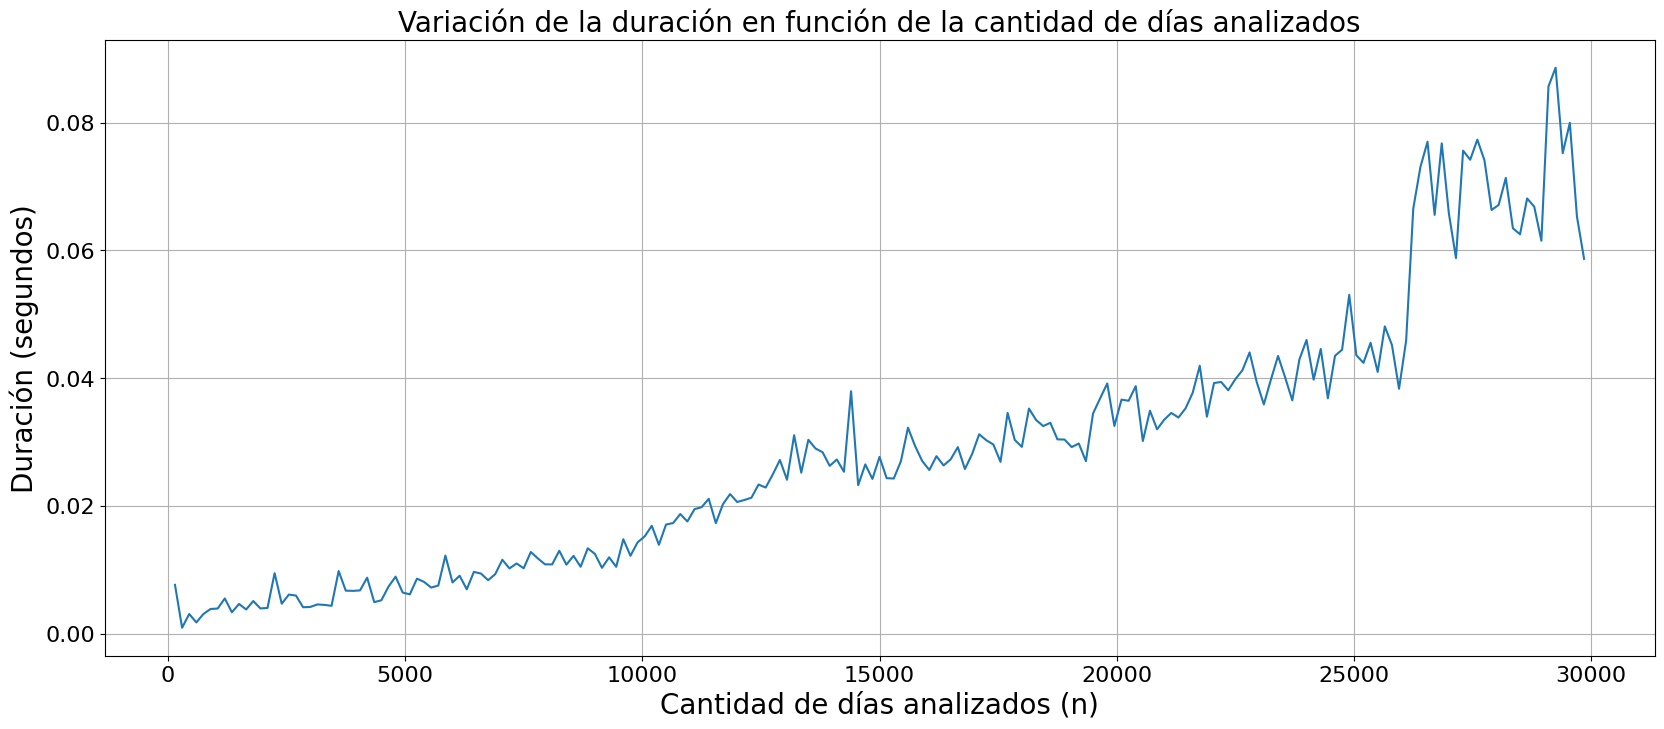

In [25]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_31)
plt.xlabel('Cantidad de días analizados (n)', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de días analizados', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

##### Algoritmo de Programacion lineal

In [26]:
def obtener_tiempos_ejecucion_LP(pedidos_prensa):
    tiempos_ejecucion = []
    i = 0
    for pedidos in pedidos_prensa:
        _, tiempo_ejecucion = solucion_para_Scaloni_LP(pedidos) 
        tiempos_ejecucion.append(tiempo_ejecucion)
        i += 1
    return tiempos_ejecucion

tiempos_ejecucion_perfo_7_lp = obtener_tiempos_ejecucion_LP(pedidos_prensa_perfo_7)
tiempos_ejecucion_perfo_31_lp = obtener_tiempos_ejecucion_LP(pedidos_prensa_perfo_31)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/carolina/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/0418ef6b510947f797f61e25346f1bc4-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/0418ef6b510947f797f61e25346f1bc4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 155 COLUMNS
At line 815 RHS
At line 966 BOUNDS
At line 998 ENDATA
Problem MODEL has 150 rows, 31 columns and 566 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 21 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 14 rows, 15 columns (15 integer (15 of which binary)) and 42 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 21
Cbc0038I Before mini branch and bound, 15 int

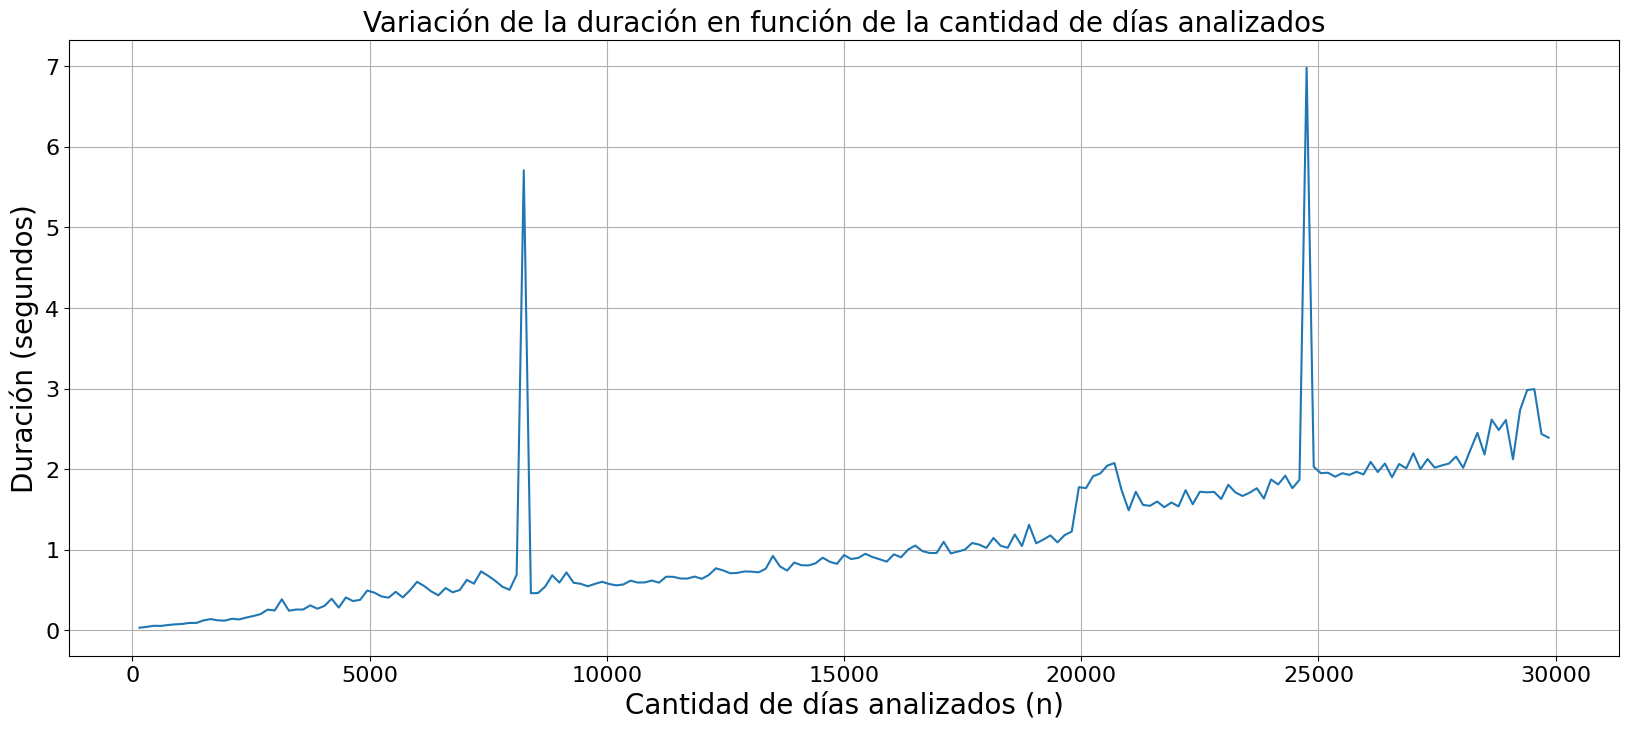

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_7_lp)
plt.xlabel('Cantidad de días analizados (n)', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de días analizados', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

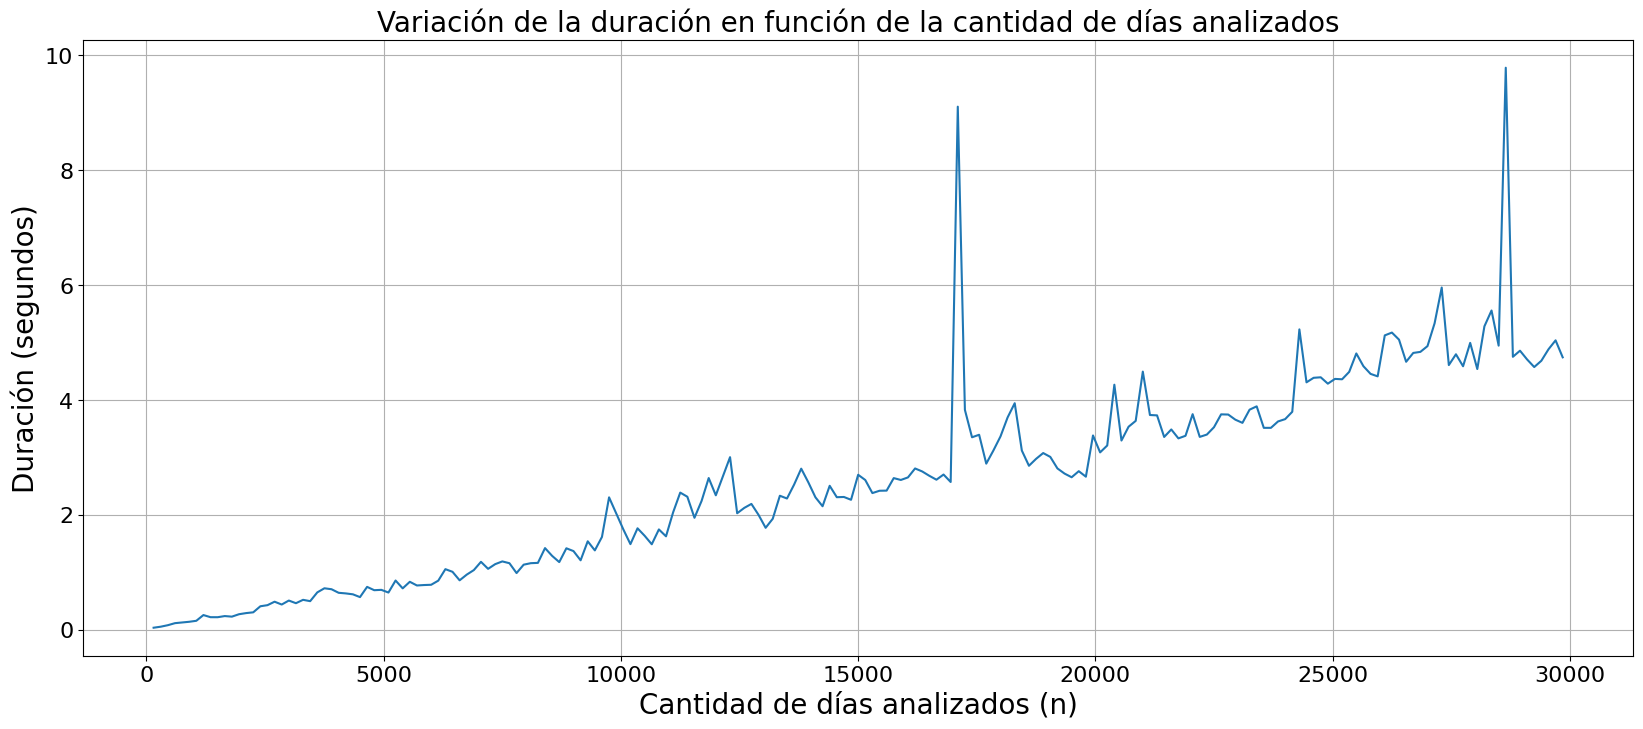

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_31_lp)
plt.xlabel('Cantidad de días analizados (n)', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de días analizados', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

##### Comparacion

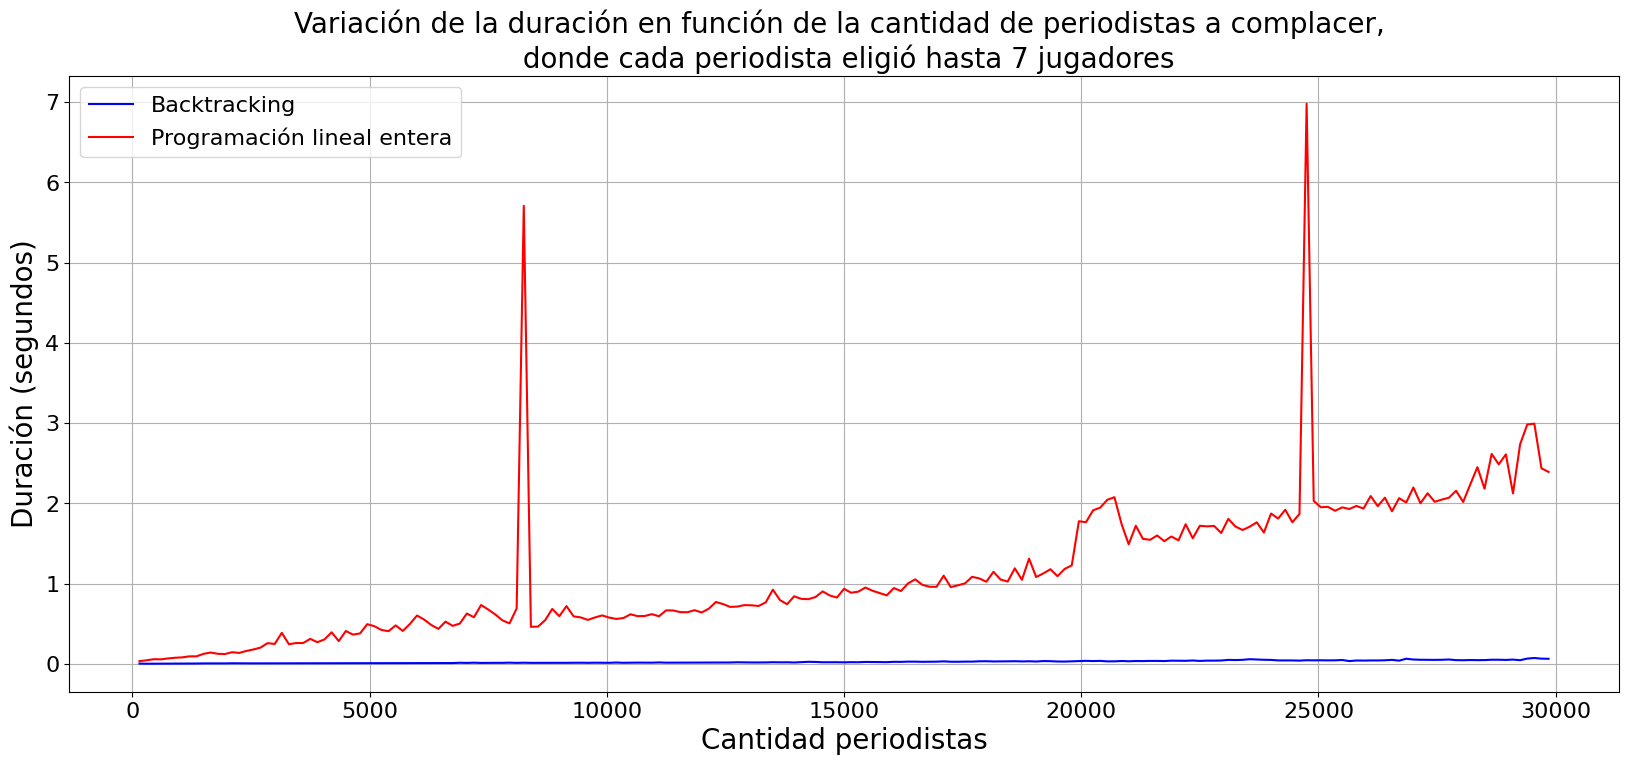

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_7, color='blue', label='Backtracking')
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_7_lp, color='red', label='Programación lineal entera')
plt.xlabel('Cantidad periodistas', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de periodistas a complacer, \n donde cada periodista eligió hasta 7 jugadores', fontsize=20)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


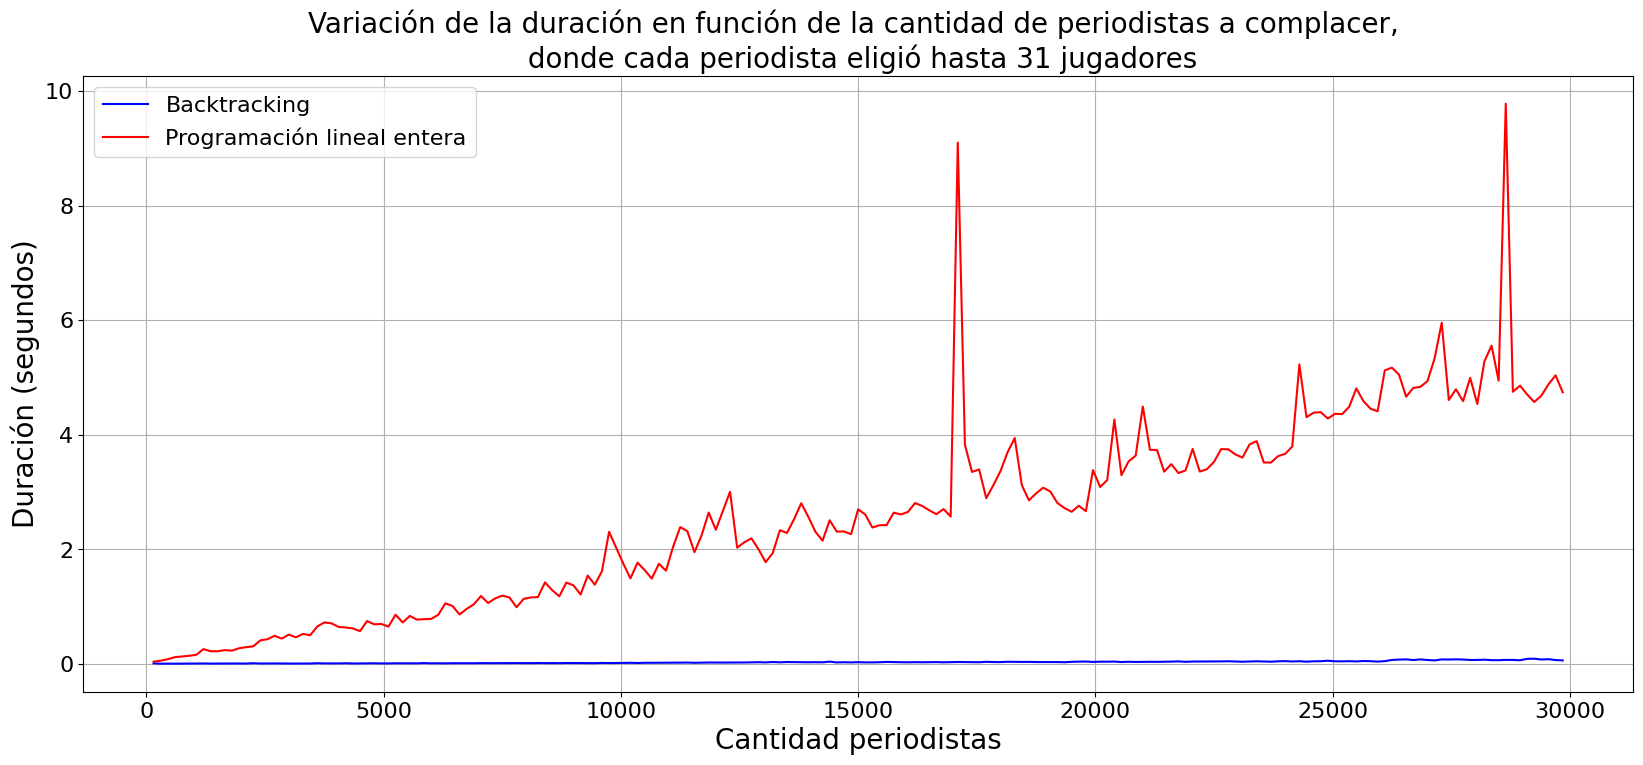

In [30]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_31, color='blue', label='Backtracking')
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_31_lp, color='red', label='Programación lineal entera')
plt.xlabel('Cantidad periodistas', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de periodistas a complacer, \n donde cada periodista eligió hasta 31 jugadores', fontsize=20)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Aproximación usando Programación Lineal y Redondeo

In [31]:
def solucion_para_Scaloni_LP_aprox(pedidos_de_prensa):
    b = len(max(pedidos_de_prensa))
    preseleccion = obtener_todos_jugadores(pedidos_de_prensa)
    tiempo_inicial = time.time()
    prob = pulp.LpProblem("Scaloni", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", preseleccion, lowBound=0, upBound=1, cat="Continuous")
    prob += pulp.lpSum([x[i] for i in preseleccion])
    
    for pedido in pedidos_de_prensa:
        prob += pulp.lpSum([x[jugador] for jugador in pedido]) >= 1
    prob.solve()
    
    # Redondeamos el resultado final
    solucion = [i for i in preseleccion if pulp.value(x[i]) >= 1/b]
    
    tiempo_final = time.time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial
    return solucion, tiempo_ejecucion

In [32]:
# Lista de resultados y tiempos
resultados_obtenidos_lp_aprox = []
# Iterar sobre los pedidos de prensa de la catedra
for archivo, value in pedidos_prensa_catedra.items():
  solucion, tiempo_ejecucion = solucion_para_Scaloni_LP_aprox(value)
  solucion = arreglar_resultado(solucion)
  resultados_obtenidos_lp_aprox.append((archivo, solucion, tiempo_ejecucion))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/carolina/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/fd450c5c828b4533828925eb050d8f4d-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/fd450c5c828b4533828925eb050d8f4d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 42 RHS
At line 48 BOUNDS
At line 59 ENDATA
Problem MODEL has 5 rows, 10 columns and 21 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 5 (0) rows, 8 (-2) columns and 18 (-3) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 0.00018121093 ( 0.018121093%) - largest zero change 0
0  Obj 0 Primal inf 4.999995 (5)
5  Obj 2.0001131
Optimal - objective value 2
After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 2 - 5 iterations time 0.002, Presolve 0.00
Option for printingOptions

In [33]:
# Imprime los resultados obtenidos y los esperados en una tabla
resultados_lp = []
i = 0
for resultado_esperado in resultados_esperados:
  archivo, solucion, tiempo_ejecucion = resultados_obtenidos_lp_aprox[i]
  es_correcto = "Sí" if resultado_esperado.cantidad_minima == len(solucion) and \
    verificar_solucion_para_Scaloni(pedidos_prensa_catedra[archivo],solucion) else "No"
  resultados_lp.append([resultado_esperado.nombre_archivo, resultado_esperado.cantidad_minima, len(solucion), es_correcto, tiempo_ejecucion]) 
  i += 1

print(tabulate(resultados_lp, headers=['Archivo', 'Cantidad mínima esperada', 'Cantidad mínima obtenida', 'Se obtuvo el resultado esperado?', 'Tiempo de ejecución (s)']))


Archivo          Cantidad mínima esperada    Cantidad mínima obtenida  Se obtuvo el resultado esperado?      Tiempo de ejecución (s)
-------------  --------------------------  --------------------------  ----------------------------------  -------------------------
5.txt                                   2                           2  Sí                                                  0.0181589
7.txt                                   2                           2  Sí                                                  0.0145802
10_pocos.txt                            3                           6  No                                                  0.0150785
10_varios.txt                           6                           6  Sí                                                  0.0161016
10_todos.txt                           10                          10  Sí                                                  0.0170236
15.txt                                  4                          11

Mostramos el resultado de los sets de datos de mayor volumen

In [34]:
# Probamos con volumenes de datos mayores:
solucion_300k_lp, tiempo_ejecucion_300k_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_nuestro['300k'])
solucion_30k_lp, tiempo_ejecucion_30k_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_nuestro['30k'])

print("Mínimo de jugadores para 300k datos: ", len(solucion_300k_lp))
print("Mínimo de jugadores para 30k datos: ", len(solucion_30k_lp))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/carolina/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/e9c93f8851a2421887e89e6bf5c79406-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/e9c93f8851a2421887e89e6bf5c79406-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 300005 COLUMNS
At line 1425890 RHS
At line 1725891 BOUNDS
At line 1725923 ENDATA
Problem MODEL has 300000 rows, 31 columns and 1125853 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-300000) rows, 0 (-31) columns and 0 (-1125853) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 31
After Postsolve, objective 31, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 31 - 0 iterations time 9.852, Presolve 9.85
Option for printingOptions changed from normal to all
Total time (CPU seconds):       11.37   (W

Vamos a verificar si la relación hallada r(A) = b se verifica

In [35]:
def relacion_aproximacion(pedidos_de_prensa, solucion, optimo):
    b = len(max(pedidos_de_prensa))
    r = len(solucion) / optimo
    return r, b

In [36]:
from tabulate import tabulate

table_data = []
i = 0
for resultado_esperado in resultados_esperados:
    archivo, solucion, tiempo_ejecucion = resultados_obtenidos_lp_aprox[i]
    r, b = relacion_aproximacion(pedidos_prensa_catedra[archivo], solucion, resultado_esperado.cantidad_minima)
    row = [
        resultado_esperado.nombre_archivo,
        resultado_esperado.cantidad_minima,
        len(solucion),
        b,
        r
    ]
    if r <= b:
        row.append("Sí")
    else:
        row.append("No")
    table_data.append(row)
    i += 1

headers = ["Archivo", "Óptimo", "Aproximación", "b", "r(A)", "Cumple relación de aproximación"]

print(tabulate(table_data, headers=headers))


Archivo          Óptimo    Aproximación    b     r(A)  Cumple relación de aproximación
-------------  --------  --------------  ---  -------  ---------------------------------
5.txt                 2               2    4  1        Sí
7.txt                 2               2    6  1        Sí
10_pocos.txt          3               6    7  2        Sí
10_varios.txt         6               6    3  1        Sí
10_todos.txt         10              10    4  1        Sí
15.txt                4              11    6  2.75     Sí
20.txt                5              12    7  2.4      Sí
50.txt                6              13    7  2.16667  Sí
75.txt                8              20    8  2.5      Sí
100.txt               9              17    5  1.88889  Sí
200.txt               9              24    7  2.66667  Sí


##### Mediciones de tiempo

In [37]:
def obtener_tiempos_ejecucion_LP_aprox(pedidos_prensa):
    tiempos_ejecucion = []
    i = 0
    for pedidos in pedidos_prensa:
        _, tiempo_ejecucion = solucion_para_Scaloni_LP_aprox(pedidos)
        tiempos_ejecucion.append(tiempo_ejecucion)
        i += 1
    return tiempos_ejecucion

tiempos_ejecucion_perfo_7_lp_aprox = obtener_tiempos_ejecucion_LP_aprox(pedidos_prensa_perfo_7)
tiempos_ejecucion_perfo_31_lp_aprox = obtener_tiempos_ejecucion_LP_aprox(pedidos_prensa_perfo_31) 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/carolina/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ef4f636a62534d71910e9f4d18ecc2eb-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/ef4f636a62534d71910e9f4d18ecc2eb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 155 COLUMNS
At line 753 RHS
At line 904 BOUNDS
At line 936 ENDATA
Problem MODEL has 150 rows, 31 columns and 566 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 14 (-136) rows, 15 (-16) columns and 41 (-525) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 0.00047050271 ( 0.047050271%) - largest zero change 0
0  Obj 16 Primal inf 13.999986 (14)
10  Obj 21.000595
Optimal - objective value 21
After Postsolve, objective 21, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 21 - 10 iterations time 0.002, Presolve 0.00
Opt

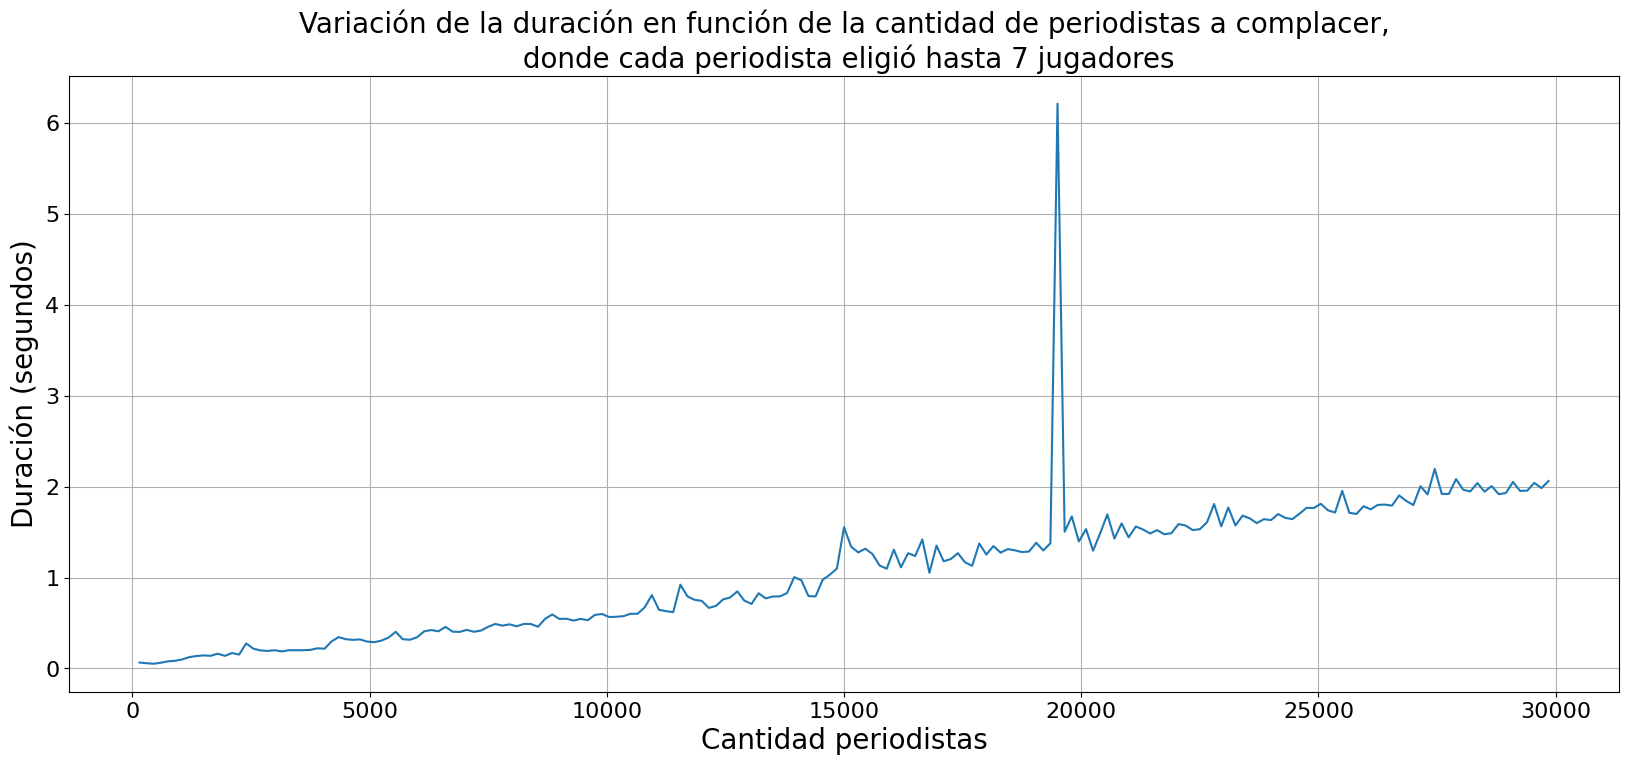

In [38]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_7_lp_aprox)
plt.xlabel('Cantidad periodistas', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de periodistas a complacer,\n donde cada periodista eligió hasta 7 jugadores', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

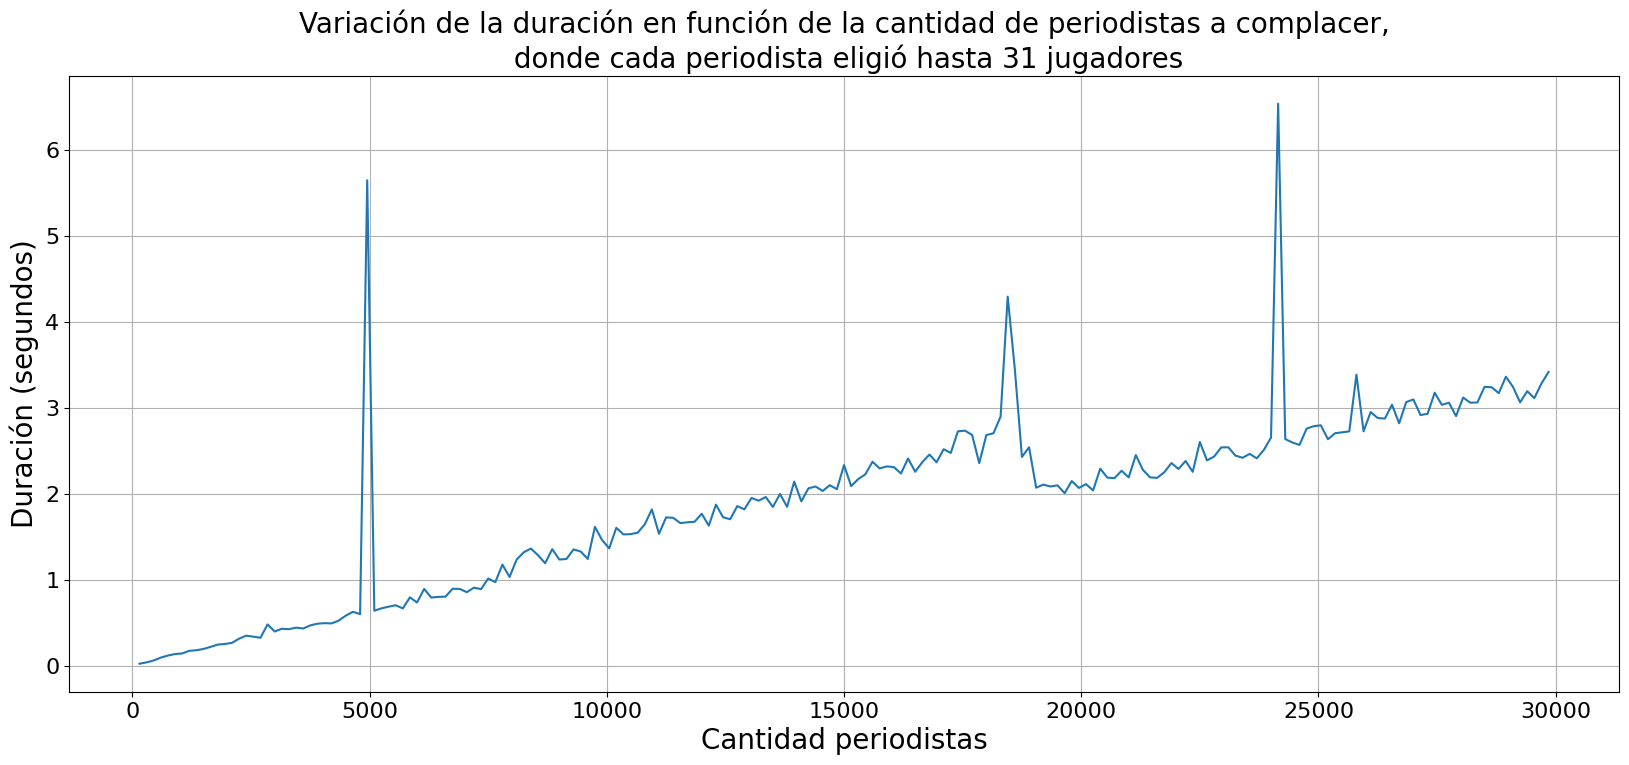

In [39]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_31_lp_aprox)
plt.xlabel('Cantidad periodistas', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de periodistas a complacer,\n donde cada periodista eligió hasta 31 jugadores', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Algoritmo Greedy

In [40]:
from collections import Counter

def ordenar_jugadores_por_apariciones(pedidos_de_la_prensa):
    jugadores = [jugador for lista in pedidos_de_la_prensa for jugador in lista]
    contador_jugadores = Counter(jugadores)
    jugadores_ordenados = sorted(contador_jugadores, key=lambda jugador: contador_jugadores[jugador], reverse=True)
    return jugadores_ordenados

def solucion_greedy(pedidos_de_la_prensa, constante):
    tiempo = time.time()
    solucionado = False
    solucion = []
    jugadores_ordenados = ordenar_jugadores_por_apariciones(pedidos_de_la_prensa)
    while not solucionado:
        jugador_actual = jugadores_ordenados[0]
        solucion.append(jugador_actual)

        if verificar_solucion_para_Scaloni(constante, solucion):
            solucionado = True
        else:
            pedidos_de_la_prensa = [lista for lista in pedidos_de_la_prensa if jugador_actual not in lista]
            jugadores_ordenados = ordenar_jugadores_por_apariciones(pedidos_de_la_prensa)

    tiempo = time.time() - tiempo
    return solucion, tiempo

#### Sets de la cátedra

In [41]:
# Lista de resultados y tiempos
resultados_obtenidos_greedy = []
# Iterar sobre los pedidos de prensa de la catedra
for archivo, value in pedidos_prensa_catedra.items():
  solucion, tiempo_ejecucion = solucion_greedy(value, value)
  resultados_obtenidos_greedy.append((archivo, solucion, tiempo_ejecucion))

# Imprime los resultados obtenidos y los esperados en una tabla
resultados = []
i = 0
for resultado_esperado in resultados_esperados:
  key, solucion, tiempo_ejecucion = resultados_obtenidos_greedy[i]
  es_valida = "Sí" if verificar_solucion_para_Scaloni(pedidos_prensa_catedra[key], solucion) else "No"
  es_correcto = "Sí" if resultado_esperado.cantidad_minima == len(solucion) and es_valida else "No"
  resultados.append([resultado_esperado.nombre_archivo, resultado_esperado.cantidad_minima, len(solucion), es_correcto,es_valida, tiempo_ejecucion]) 
  i += 1
print(tabulate(resultados, headers=['Archivo', 'Cantidad mínima esperada', 'Cantidad mínima obtenida', 'Se obtuvo el resultado esperado?', 'Es Válida', 'Tiempo de ejecución (s)']))
  

Archivo          Cantidad mínima esperada    Cantidad mínima obtenida  Se obtuvo el resultado esperado?    Es Válida      Tiempo de ejecución (s)
-------------  --------------------------  --------------------------  ----------------------------------  -----------  -------------------------
5.txt                                   2                           2  Sí                                  Sí                         0.000263929
7.txt                                   2                           2  Sí                                  Sí                         6.00815e-05
10_pocos.txt                            3                           3  Sí                                  Sí                         0.000252724
10_varios.txt                           6                           7  No                                  Sí                         0.000266075
10_todos.txt                           10                          10  Sí                                  Sí               

#### Sets nuestros

In [42]:
# Lista de resultados y tiempos
resultados_obtenidos_greedy_nuestros = []
# Iterar sobre los pedidos de prensa de la catedra
for archivo, value in pedidos_prensa_nuestro.items():
  solucion, tiempo_ejecucion = solucion_greedy(value, value)
  resultados_obtenidos_greedy_nuestros.append((archivo, solucion, tiempo_ejecucion))


# Imprime los resultados obtenidos y los esperados en una tabla
resultados_nuestros_greedy = []
i = 0
for resultado_obtenido in resultados_obtenidos_greedy_nuestros:
  archivo, solucion, tiempo_ejecucion = resultado_obtenido
  es_correcto = "Sí" if verificar_solucion_para_Scaloni(pedidos_prensa_nuestro[archivo], solucion) else "No"
  resultados_nuestros_greedy.append([archivo + '.txt', len(solucion), es_correcto , tiempo_ejecucion]) 
  i += 1
print(tabulate(resultados_nuestros_greedy, headers=['Archivo', 'Cantidad minima obtenida', 'Es válida la solución?', 'Tiempo de ejecución (s)']))

Archivo              Cantidad minima obtenida  Es válida la solución?      Tiempo de ejecución (s)
-----------------  --------------------------  ------------------------  -------------------------
5.txt                                       3  Sí                                      7.62939e-05
15.txt                                      5  Sí                                      0.000415087
15_un_jugador.txt                          14  Sí                                      0.000266075
20.txt                                      8  Sí                                      0.000246763
50.txt                                     20  Sí                                      0.000786543
30k.txt                                    31  Sí                                      0.297744
300k.txt                                   31  Sí                                      2.22032


## Sección para pruebas del Usuario

### Backtracking

In [43]:
path = "sets/sets de la catedra/200.txt"
pedidos_de_prensa = obtener_pedidos_de_la_prensa(path)
solucion, tiempo_ejecucion = solucion_para_Scaloni_BT(pedidos_de_prensa)
print("Solucion:", solucion, "\nTiempo de ejecucion:", tiempo_ejecucion)


Solucion: ['Dibu', 'Messi', 'Gallardo', 'Pity Martinez', 'El fantasma de la B', 'Beltran', 'Luka Romero', 'Burrito Ortega', "Barcon't"] 
Tiempo de ejecucion: 7.105724096298218


### Programacion lineal entera

In [44]:
path = "sets/sets de la catedra/50.txt"
pedidos_de_prensa = obtener_pedidos_de_la_prensa(path)
solucion, tiempo_ejecucion = solucion_para_Scaloni_LP(pedidos_de_prensa)
solucion = arreglar_resultado(solucion)
print("Solucion:", solucion, "\nTiempo de ejecucion:", tiempo_ejecucion)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/carolina/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/11a6a71706f548a4a3b1e3cf86d071bc-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/11a6a71706f548a4a3b1e3cf86d071bc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 55 COLUMNS
At line 466 RHS
At line 517 BOUNDS
At line 549 ENDATA
Problem MODEL has 50 rows, 31 columns and 317 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5.17778 - 0.00 seconds
Cgl0004I processed model has 50 rows, 31 columns (31 integer (31 of which binary)) and 317 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 19 integers unsatisfied sum - 4.42222
Cbc0038I Pass   1: suminf.    2.20000 (7) obj. 5.6 iterations 20
Cbc0038I Pass   2: suminf.    0.00000 (0) obj. 6 iterations 4
Cbc0038I Sol

### Programacion lineal

In [45]:
path = "sets/sets de la catedra/75.txt"
pedidos_de_prensa = obtener_pedidos_de_la_prensa(path)
solucion, tiempo_ejecucion = solucion_para_Scaloni_LP_aprox(pedidos_de_prensa)
solucion = arreglar_resultado(solucion)
print("Solucion:", solucion, "\nTiempo de ejecucion:", tiempo_ejecucion)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/carolina/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/7fbf841eef2c47ada98c89df6b6526ed-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/7fbf841eef2c47ada98c89df6b6526ed-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 80 COLUMNS
At line 570 RHS
At line 646 BOUNDS
At line 678 ENDATA
Problem MODEL has 75 rows, 31 columns and 458 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 75 (0) rows, 31 (0) columns and 458 (0) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 9.6816743e-05 ( 0.0096816743%) - largest zero change 0
0  Obj 0 Primal inf 74.999993 (75)
31  Obj 5.5026398 Primal inf 6.1463394 (21)
52  Obj 6.0188347
Optimal - objective value 6.018648
Optimal objective 6.018648019 - 52 iterations time 0.002
Option for printingOptions changed from no

### Greedy

In [46]:
path = "sets/sets de la catedra/10_todos.txt"
pedidos_de_prensa = obtener_pedidos_de_la_prensa(path)
solucion = solucion_greedy(pedidos_de_prensa, pedidos_de_prensa)
print(solucion)


(['Dibu', 'Cuti', 'Molina', 'Guido Rodriguez', 'Paredes', 'Palacios', 'Messi', 'Garnacho', 'Lautaro', 'Perrone'], 0.00037169456481933594)
